# 共通処理

In [1]:
!pip install -q keras
import keras

Using TensorFlow backend.


In [2]:
from google.colab import files

uploaded = files.upload()

Saving student-50k.txt to student-50k.txt
Saving tutor-50k.txt to tutor-50k.txt


In [0]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

# 読み込み＆Tokenizerによる数値化
train_X, tokenizer_st = load_data('student-50k.txt')
train_Y, tokenizer_tu = load_data('tutor-50k.txt')

st_vocab_size = len(tokenizer_st.word_index) + 1
tu_vocab_size = len(tokenizer_tu.word_index) + 1

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.02, random_state=42)

# パディング
train_X = pad_sequences(train_X, padding='post')
train_Y = pad_sequences(train_Y, padding='post')

seqX_len = len(train_X[0])
seqY_len = len(train_Y[0])

In [4]:
print(st_vocab_size)
print(tu_vocab_size)

12507
14950


# 学習

In [0]:
from keras.models import Model
from keras.layers import Input, Permute, Activation, Embedding, Dense, LSTM, concatenate, dot
from keras import backend as K

emb_dim = 256
hid_dim = 256
att_dim = 256

# 符号化器
encoder_inputs = Input(shape=(seqX_len,))
encoder_embeded = Embedding(st_vocab_size, emb_dim, mask_zero=True)(encoder_inputs)
encoded_seq, *encoder_states = LSTM(hid_dim, return_sequences=True, return_state=True)(encoder_embeded)

# 復号化器（encoder_statesを初期状態として指定）
decoder_inputs = Input(shape=(seqY_len,))
decoder_embeding = Embedding(tu_vocab_size, emb_dim)
decoder_embeded = decoder_embeding(decoder_inputs)
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True)
decoded_seq, _, _ = decoder_lstm(decoder_embeded, initial_state=encoder_states)

# Attention
score_dense = Dense(hid_dim)
score = score_dense(decoded_seq)
score = dot([score, encoded_seq], axes=(2,2))
attention = Activation('softmax')(score)
context = dot([attention, encoded_seq], axes=(2,1))
concat = concatenate([context, decoded_seq], axis=2)
attention_dense = Dense(att_dim, activation='tanh')
attentional = attention_dense(concat)
output_dense = Dense(tu_vocab_size, activation='softmax')
outputs = output_dense(attentional)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
import numpy as np
from keras.callbacks import EarlyStopping

train_target = np.hstack((train_Y[:, 1:], np.zeros((len(train_Y),1), dtype=np.int32)))

early_stopping = EarlyStopping(patience=1, verbose=1)

fit = model.fit([train_X, train_Y], np.expand_dims(train_target, -1), batch_size=128, epochs=20, verbose=2, validation_split=0.2, callbacks=[early_stopping])

Train on 39200 samples, validate on 9800 samples
Epoch 1/20
 - 807s - loss: 0.3497 - acc: 0.9652 - val_loss: 0.1868 - val_acc: 0.9710
Epoch 2/20
 - 809s - loss: 0.1752 - acc: 0.9724 - val_loss: 0.1708 - val_acc: 0.9730
Epoch 3/20
 - 810s - loss: 0.1640 - acc: 0.9740 - val_loss: 0.1635 - val_acc: 0.9742
Epoch 4/20
 - 809s - loss: 0.1568 - acc: 0.9748 - val_loss: 0.1587 - val_acc: 0.9746
Epoch 5/20
 - 808s - loss: 0.1521 - acc: 0.9753 - val_loss: 0.1568 - val_acc: 0.9749
Epoch 6/20
 - 804s - loss: 0.1483 - acc: 0.9758 - val_loss: 0.1562 - val_acc: 0.9751
Epoch 7/20
 - 800s - loss: 0.1451 - acc: 0.9761 - val_loss: 0.1548 - val_acc: 0.9753
Epoch 8/20
 - 806s - loss: 0.1423 - acc: 0.9765 - val_loss: 0.1545 - val_acc: 0.9753
Epoch 9/20
 - 808s - loss: 0.1396 - acc: 0.9768 - val_loss: 0.1541 - val_acc: 0.9752
Epoch 10/20
 - 809s - loss: 0.1370 - acc: 0.9771 - val_loss: 0.1538 - val_acc: 0.9754
Epoch 11/20
 - 808s - loss: 0.1345 - acc: 0.9774 - val_loss: 0.1540 - val_acc: 0.9754
Epoch 00011: e

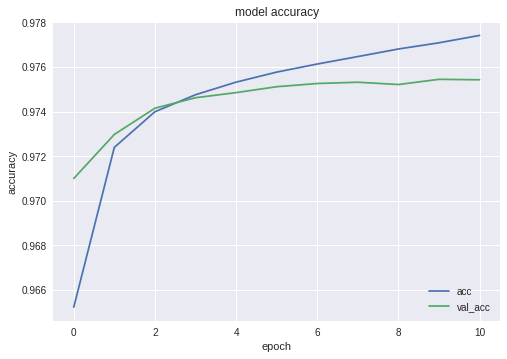

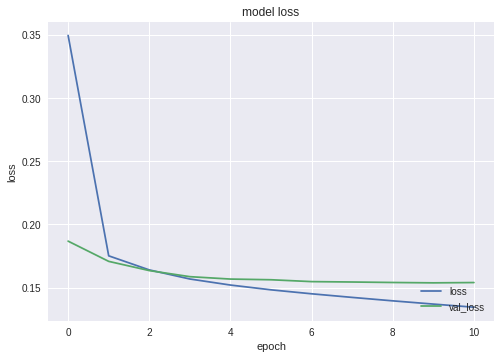

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(fit.history)

モデルをファイルに保存する。

In [19]:
model.save('./s2s-50k.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [0]:
files.download('./s2s-50k.h5')

# 予測

モデルをファイルから読み込む。

In [5]:
from google.colab import files

uploaded = files.upload()

Saving s2s-50k.h5 to s2s-50k.h5


In [0]:
from keras.models import Model
from keras.layers import Input, Permute, Activation, Embedding, Dense, LSTM, concatenate, dot
from keras import backend as K

emb_dim = 256
hid_dim = 256
att_dim = 256

# 符号化器
encoder_inputs = Input(shape=(seqX_len,))
encoder_embeded = Embedding(st_vocab_size, emb_dim, mask_zero=True)(encoder_inputs)
encoded_seq, *encoder_states = LSTM(hid_dim, return_sequences=True, return_state=True)(encoder_embeded)

# 復号化器（encoder_statesを初期状態として指定）
decoder_inputs = Input(shape=(seqY_len,))
decoder_embeding = Embedding(tu_vocab_size, emb_dim)
decoder_embeded = decoder_embeding(decoder_inputs)
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True)
decoded_seq, _, _ = decoder_lstm(decoder_embeded, initial_state=encoder_states)

# Attention
score_dense = Dense(hid_dim)
score = score_dense(decoded_seq)
score = dot([score, encoded_seq], axes=(2,2))
attention = Activation('softmax')(score)
context = dot([attention, encoded_seq], axes=(2,1))
concat = concatenate([context, decoded_seq], axis=2)
attention_dense = Dense(att_dim, activation='tanh')
attentional = attention_dense(concat)
output_dense = Dense(tu_vocab_size, activation='softmax')
outputs = output_dense(attentional)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.load_weights('./s2s-50k.h5')

In [0]:
encoder_model = Model(encoder_inputs, [encoded_seq]+encoder_states)

decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]

decoder_inputs = Input(shape=(1,))
decoder_embeded = decoder_embeding(decoder_inputs)
decoded_seq, *decoder_states = decoder_lstm(decoder_embeded, initial_state=decoder_states_inputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoded_seq] + decoder_states)

# Attention
encoded_seq_in, decoded_seq_in = Input(shape=(seqX_len, hid_dim)), Input(shape=(1, hid_dim))
score = score_dense(decoded_seq_in)
score = dot([score, encoded_seq_in], axes=(2,2))
attention = Activation('softmax')(score)
context = dot([attention, encoded_seq_in], axes=(2,1))
concat = concatenate([context, decoded_seq_in], axis=2)
attentional = attention_dense(concat)
attention_outputs = output_dense(attentional)

attention_model = Model([encoded_seq_in, decoded_seq_in], [attention_outputs, attention])

貪欲decodingによる予測

In [0]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    encoded_seq, *states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])
    output_seq = bos_eos[0]
    attention_seq = np.empty((0,len(input_seq[0])))
    
    while True:
        decoded_seq, *states_value = decoder_model.predict([target_seq] + states_value)
        output_tokens, attention = attention_model.predict([encoded_seq, decoded_seq])
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        attention_seq = np.append(attention_seq, attention[0], axis=0)
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq, attention_seq

In [10]:
import numpy as np

detokenizer_st = dict(map(reversed, tokenizer_st.word_index.items()))
detokenizer_tu = dict(map(reversed, tokenizer_tu.word_index.items()))

text_no = 4
input_seq = pad_sequences([test_X[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_tu.texts_to_sequences(["<s>", "</s>"])

output_seq, attention_seq = decode_sequence(input_seq, bos_eos)

print('元の文:', ' '.join([detokenizer_st[i] for i in test_X[text_no]]))
print('生成文:', ' '.join([detokenizer_tu[i] for i in output_seq]))
print('正解文:', ' '.join([detokenizer_tu[i] for i in test_Y[text_no]]))

元の文: <s> はい </s>
生成文: <s> では </s>
正解文: <s> では 進み ます </s>


beam searchで尤もらしい5つの返事を生成する。

In [0]:
def beam_search(input_seq, bos_eos, max_output_length = 1000, k=5):
    encoded_seq, *states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])
    output_seq = bos_eos[0]
    attention_seq = np.empty((0,len(input_seq[0])))

    candidates = [[0, target_seq, output_seq, states_value]]
    t = 0

    while t < max_output_length:
        t += 1
        tmp_candidates = []
        end_flag = True
        for score_tm1, target_seq, output_seq, states_value in candidates:
            if target_seq[0] == bos_eos[1]:
                tmp_candidates.append([score_tm1, target_seq, output_seq, states_value])
            else:
                end_flag = False
                decoded_seq, *states_value = decoder_model.predict([target_seq] + states_value)
                output_tokens, attention = attention_model.predict([encoded_seq, decoded_seq])
                # 対数化
                loged_output_tokens = np.log(output_tokens[0, -1, :])
                # 確率の高い単語とそのidを取得
                y_t, s_t = np.argsort(loged_output_tokens)[::-1][:k], np.sort(loged_output_tokens)[::-1][:k]
                # スコア (対数尤度) を蓄積
                score_t = score_tm1 + s_t
                # すべての候補を一時的に保管
                tmp_candidates.extend(
                    [[score_tk, np.array([y_tk]), np.append(output_seq, y_tk), states_value]
                        for score_tk, y_tk in zip(score_t, y_t)]
                )
        if end_flag:
            break

        # 正規化したスコアでソートし, 上位K個の候補を保存
        candidates = sorted(tmp_candidates, key=lambda x: -x[0]/len(x[2]))[:k]
    output_seqs = []
    for c in candidates:
        output_seqs.append(c[2])

    return output_seqs

In [10]:
import numpy as np

detokenizer_st = dict(map(reversed, tokenizer_st.word_index.items()))
detokenizer_tu = dict(map(reversed, tokenizer_tu.word_index.items()))

text_no = 320
input_seq = pad_sequences([test_X[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_tu.texts_to_sequences(["<s>", "</s>"])

output_seqs = beam_search(input_seq, bos_eos)

print('元の文:', ' '.join([detokenizer_st[i] for i in test_X[text_no]]))
for seq in output_seqs:
    print('生成文:', ' '.join([detokenizer_tu[i] for i in seq]))
print('正解文:', ' '.join([detokenizer_tu[i] for i in test_Y[text_no]]))

元の文: <s> あり まーす </s>
生成文: <s> そう だ ね </s>
生成文: <s> そう だ よ ね </s>
生成文: <s> うん </s>
生成文: <s> はい </s>
生成文: <s> そう だ よ </s>
正解文: <s> おおいい ね </s>


# 評価

共通処理

In [0]:
from nltk.translate.bleu_score import sentence_bleu

def padding(s):
  if len(s) < 4:
    s = pad_sequences([s], 4, value=2, padding='post')[0] # value=2 は、'</s>'
  return s

bos_eos = tokenizer_tu.texts_to_sequences(["<s>", "</s>"])
detokenizer_tu = dict(map(reversed, tokenizer_tu.word_index.items()))


greedy decodingによるBLEU値

In [83]:
output_seqs = [
    decode_sequence(pad_sequences([test_X[i]], seqX_len, padding='post'), tokenizer_tu.texts_to_sequences(["<s>", "</s>"]))[0]
    for i in range(len(test_X))
]

preds = [[detokenizer_tu[i] for i in padding(seq)] for seq in output_seqs]
refs = [[detokenizer_tu[j] for j in padding(test_Y[i])] for i in range(len(test_Y))]
print(np.mean([sentence_bleu([ref], pred) for ref, pred in zip(refs, preds)]))

0.4909378251237181


beam searchによるBLEU値（5つの生成メッセージ中の最良のBLUE値の平均）

In [12]:
output_seqs = [
    beam_search(pad_sequences([test_X[i]], seqX_len, padding='post'), bos_eos)
    for i in range(len(test_X))
]

predss = [[[detokenizer_tu[i] for i in padding(seq)] for seq in seqs] for seqs in output_seqs]
refs = [[detokenizer_tu[j] for j in padding(test_Y[i])] for i in range(len(test_Y))]
print(np.mean([np.max([sentence_bleu([ref], pred) for pred in preds]) for ref, preds in zip(refs, predss)]))

0.6177252973643976


beam searchによるBLEU値（最尤の生成メッセージのBLEU値の平均）

In [13]:
output_seqs = [
    beam_search(pad_sequences([test_X[i]], seqX_len, padding='post'), bos_eos)
    for i in range(len(test_X))
]

predss = [[[detokenizer_tu[i] for i in padding(seq)] for seq in seqs] for seqs in output_seqs]
refs = [[detokenizer_tu[j] for j in padding(test_Y[i])] for i in range(len(test_Y))]
print(np.mean([sentence_bleu([ref], preds[0]) for ref, preds in zip(refs, predss)]))

0.5140164492587093
